<a href="https://colab.research.google.com/github/RyanMoussouni/Machine-Learning/blob/master/Veepee_Swipe_and_Learn_Gabriel_Cuny_Ryan_Moussouni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

- Python version 3.7.x
- `pip install -u pip`
- `pip install -r requirements.txt`

## Problem description

#### Veepee's business description

Veepee is an online flash sales website which offers a large number of new sales everyday with huge discounts up to 70%. Sales are available for a very short period of time.

On Veepee's website, there are **about 200 flash sales on the home page** on a given day divided into several sectors like fashion, accessories, toys, watches, home appliances, sports equipment, technology, wines, travel, etc.

New sales open every day and old sales either continue or stop.

#### Homepage recommendation problem

Because the number of sales (also called operations) is important, users might not scroll until the end of the homepage to see all the banners and might leave Veepee if no sales at the top of the page are relevant to them.

Thus, the main goal of the homepage customization will be to rank the banners so that the most relevant active sales for a customer appear on top of the page.

For that, we rely on the user's previous orders and preferences but also on sales popularity and other global information.

#### First connection issue

Because the ranking algorithm uses members features which are processed once a day, when a user comes for the first time, its home page is not personalized until the next day.

**The goal of these notebooks is to make a first ranking by presenting the user some operations and ask him if he is interested or not.**

# 1 - Random propositions

## Imports

In [1]:
import pandas as pd
import random

In [2]:
random.seed(84)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd drive/MyDrive

/content/drive/MyDrive


## Loading the data

The dataframe contains the features of the operation and the related banner. For the train we took all the operations displayed on the homepage on `2020-08-04` (these operation can be new operations or ongoing ones). For the test set, we only took the operations which started in `2020-10-30`.

In [6]:
train_ops = pd.read_pickle("train_2020-08-04.pickle")
test_ops = pd.read_pickle("test_2020-10-30.pickle")

### Operations features

In [ ]:
train_ops.head(20)

,operationcd,secteur_principal,sous_secteur_principal,business_type,brand,operation_type,front_secteur,front_sous_secteur,banner
0,RCLOUD5,DECO / MEUBLE,LITERIE,Vente privée,ROYAL CLOUD,Classique,Maison,Ameublement,b'\xff\xd8\xff\xed\x01\xecPhotoshop 3.0\x008BI...
1,PBOTTLE4,MATERIEL SPORT,MATÉRIEL OUTDOOR,Vente privée,POP BOTTLES,Classique,Sport,Matériel de sport,b'\xff\xd8\xff\xed\x01\xecPhotoshop 3.0\x008BI...
2,JDA9,PARCS,PARC D'ATTRACTION,Entertainment,LE JARDIN D ACCLIMATATION_BILLETTERIE,VBI interne,INCONNU,INCONNU,b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\...
3,BRAX8,PAP FEMME,CLASSIQUE,Vente privée,BRAX,Classique,Mode,Vêtements Femme,b'\xff\xd8\xff\xed\x01\xd6Photoshop 3.0\x008BI...
4,CCO37,DIVERS,DIVERS,Vente privée,CONDOMS & CO,Classique,INCONNU,INCONNU,b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\...
5,CSHO2,CHAUSSURES,SPORT,Vente privée,CHAMPION SHOES,Classique,Sport,Chaussures de sport,b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\...
6,KSIX2,HIGH TECH,ACCESSOIRES,Vente privée,KSIX,Classique,INCONNU,INCONNU,b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\...
7,ORY14,LINGERIE,LINGERIE FEMME,Vente privée,ORY,Classique,Mode,Lingerie,b'\xff\xd8\xff\xe1\r\xe3Exif\x00\x00II*\x00\x0...
8,AMARA1,DECO / MEUBLE,DÉCORATION,Vente privée,AMARA,Classique,Maison,Décoration,b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\...
9,GSEB28,PEM,CUISINE,Vente privée,GROUPE SEB,Classique,Maison,Electroménager,b'\xff\xd8\xff\xe1\r\x11Exif\x00\x00II*\x00\x0...


- `operationcd`: code of the operation
- `secteur_principal`: first level of two of the internal taxonomy
- `sous_secteur_principal`: second level of two of the internal taxonomy
- `business_type`: 'Vente privée', 'Entertainment', 'MEDIA', 'Vin', 'One Day', 'Voyage'
- `brand`: name of the brand
- `operation_type`: 'Classique', 'VBI interne', 'Thématique', 'Vin classique', 'One Day', 'Hotel Planet', 'Séquence caviste'
- `front_secteur`: first level of two of the homepage taxonomy
- `front_sous_secteur`: second level of two of the homepage taxonomy

### Operations banners

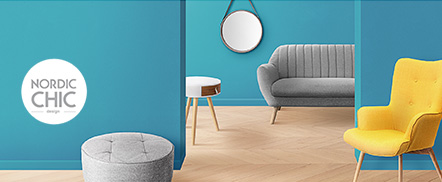

In [ ]:
from IPython import display
from base64 import b64decode

display.Image(train_ops.loc[56].banner)

So the homepage consists on 200 banners like this one displayed in two columns. On the banner you will have the brand name of the operation and a specific visual.

## Exercice Setup

In the next cells we will simulate a small survey given to a new user:

We will display operations randomly and ask the user for his/her interest. Each operation is selected completely randomly.

In [ ]:
# Imports
from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout 

In [ ]:
# Add empty column to record actions
train_ops['interested'] = None
test_ops['interested'] = None

In [ ]:
def create_expanded_button(description, button_style):
    return Button(
        description=description,
        button_style=button_style,
        layout=Layout(height='auto', width='auto')
    )


def random_row():
    return random.randint(0, len(train_ops) - 1)


def get_banner(index, dataset):
    return Image(
        value=dataset.loc[index].banner,
        format='jpg',
        width=300,
        height=400,
    )


def plot_grid(df):
    n_rows = (len(df)//3) + (len(df) % 3 != 0)
    grid = GridspecLayout(n_rows , 3)

    cpt = 0
    for i in range(n_rows):
        for j in range(3):
            if cpt < len(df):
                grid[i, j] = get_banner(df.index[cpt], df)
                cpt += 1 
    return grid

In [ ]:
import matplotlib.pyplot as plt
# Setting the left button: Not Interested
left_button = create_expanded_button('Not Interested', 'danger')

# Setting the image in the center
current_row_number = random_row()
img = get_banner(current_row_number, train_ops)

# Setting the right button: Interested
right_button = create_expanded_button('Interested', 'success')


def on_button_clicked(b):
    """
    Update the values related to the users choice
    Choose a new operation to display
    Update the banner displayed
    """
    update_values(b)
    row_number = choose_row_number()
    update_banner(b, row_number)
    print('Clicked')

def update_values(b):
    """
    Update the dataframe column "interested" using user's action
    """
    global current_row_number

    interested = b.description == "Interested"
    train_ops.loc[current_row_number, 'interested'] = interested
    print('Done')
    

def choose_row_number():
    """
    Choose randomly a new operation not already seen
    """
    row_number = random_row()
    if train_ops.loc[row_number].interested is None:
        return row_number
    
    while(train_ops.loc[row_number].interested is not None):
        row_number = random_row()
    
    return row_number


def update_banner(b, row_number):
    """
    Update the value of the image widget with the new banner's string
    """
    global current_row_number

    current_row_number = row_number
    banner = train_ops.loc[current_row_number].banner
    img.value = banner

# Set the on_click function to the button
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

# https://ipywidgets.readthedocs.io/en/stable/examples/Layout%20Templates.html#AppLayout
app =AppLayout(
    left_sidebar=left_button,
    center=img,
    right_sidebar=right_button
)

In [ ]:
app

AppLayout(children=(Button(button_style='danger', description='Not Interested', layout=Layout(grid_area='left-…

### Sum up operations seen

In [ ]:
len(viewed_ops)

28

#### Liked

In [ ]:
viewed_ops = train_ops[~train_ops['interested'].isna()]
plot_grid(viewed_ops[viewed_ops.interested])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\x08\x00\x00\x00\x00\x00\x00…

#### Not Liked

In [ ]:
plot_grid(viewed_ops[~viewed_ops.interested.astype(bool)])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xed\x01\xecPhotoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x…

## Learn and Predict

### Logistic Regression

Let us first implement a simple logistic regression and learn the user's preferences.

We will then be able to rank the test operations based on the previous feedbacks.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [148]:
###############################################################################
# - Train simple Logistic Regression model on the features and feedbacks      #
# - Make predictions on the test set                                          #
# - Add a new column to the test set with the predicted values                #
###############################################################################


# -- Selecting relevant data
ids_train = np.where(train_ops['interested'].notna())[0]
columns = ['secteur_principal',
           'sous_secteur_principal',
           'business_type',
           'brand',
           'operation_type',
           'front_secteur',
           'front_sous_secteur']

xTrain = train_ops.iloc[ids_train][columns]
yTrain = train_ops.iloc[ids_train]['interested'].astype('uint8')

xTest = test_ops[columns]


# -- Encoding the categorical features
ohe = OneHotEncoder()
data = train_ops[columns].append(test_ops[columns])
ohe.fit(data) # fit the whole data to have all categories

xTrain_ohe = ohe.transform(xTrain)
assert xTrain_ohe.shape[0] == xTrain.shape[0]

xTest_ohe = ohe.transform(xTest)
assert xTest_ohe.shape[0] == xTest.shape[0]

assert xTest_ohe.shape[1] == xTrain_ohe.shape[1]

print('n_samples: ', xTrain_ohe.shape[0])
print('n_features: ', xTrain_ohe.shape[1])

# -- Fitting
C0 = 1e9 # no regularization at first
clf = LogisticRegression(C= C0)

%time clf.fit(xTrain_ohe, yTrain)

# -- Predictions
yPred = clf.predict_proba(xTest_ohe)
test_ops['prediction'] = yPred[:,1]

# -- Scoring
scoreTrain = clf.score(xTrain_ohe, yTrain)
#scoreTest = clf.score(xTest_ohe, yTest)

###############################################################################

sorted_ops = test_ops.sort_values(by="prediction", ascending=False)

n_samples:  26
n_features:  315
CPU times: user 11.7 ms, sys: 58 µs, total: 11.8 ms
Wall time: 11.6 ms


#### Display ranking on test

In [149]:
plot_grid(sorted_ops)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xed\x02\x06Photoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x…

### Conclusions

###############################################################################

Your conclusions

**Proposal**

The strategy is completely randomized, so you might end up proposing a lot of times operations that the user dislikes. There are better strategies.


**Predictions** 

 It works as expected, when user tastes are simple

  - First run: to build the train data, we said Lingerie, beauty products, and women clothes interest me. The rest we put as not interested. We got recommended mostly Lingerie and beauty products.

  - Second run: We said we were interested only in travels. The rest we said we ere not interested. We gave him 28 training samples. The first two operations that we get recommanded are the only two travels in the test operations.
  
**Limit**
 
 If you like to travel, but not all travels proposed interest you, (say you want to go to Tahiti, but travels in France don't interest you), you might not get recommended travels.





###############################################################################

In [ ]:
%reset -f

# 2 - Online Learning

## The Contextual Bandit

The Contextual Bandit is just like the Multi-Armed bandit problem but now the reward probability distribution depends on external variables. Therefore, we add the notion of **context** or **state** to support our decision.

We're going to suppose that the probabilty of reward is of the form

$$\theta(x) = \frac{1}{1 + exp(-f(x))}$$

where 

$$f(x) = \beta_0 + \sum_{i=0}^{d}{\beta_i \cdot x_i} + \epsilon$$

which is just assuming that the probability of reward linearly depends of an external variable $x$ with logistic link.

- $x$: the context. Features of the operation.
- $d$: size of the context
- $\beta_i$: the param learned to predict the probability of interest
- $\theta(x)$: The logistic normalization to compute the probability of reward

### Logistic Regression

Let us implement a regular logistic regression, and use an $\epsilon$-greedy policy to choose which bandit to activate. We try to learn the logistic function behind each bandit:

$$\theta(x) = \frac{1}{1 + exp(-f(x))}$$

where 

$$f(x) = \beta_0 + \sum_{i=0}^{d}{\beta_i \cdot x_i} + \epsilon$$

And select the operation which maximizes $\theta(x)$, except when, with $\epsilon$ probability, we select a random action (excluding the greedy action).

**Theoretical resolution**:

Here we have 
- $\mathscr{R} = \{0,1\}$
- $\mathscr{A_t} = \{\text{remaining operations in the training set}  \}$


The goal of the contextual bandit problem is to maximise the cumulative reward at time $t$:
$$ \sum_\tau^t R_\tau $$

Here the set of actions decreases $\mathscr{A_t}$ over time.

Given a state and an action, we chose to estimate the state value function by the following variationnal family of functions:

$$Q(a) = \mathbb{E}(R | A=a) \approx \hat{Q}_{\beta}(a) = \theta_\beta(a)$$ 

For the epsilon greedy strategy,
at state $t$ we take action $a_t$ defined by:
- $a_t = \text{arg} \max_{a \in \mathscr{A_t}} \hat{Q_{\beta_{t-1}}}(a) $ with probability $1 - \epsilon$, where the parameters $(\beta_t)_t$ are estimated  by a logistic regression on $(A_1, R_1), ... (A_{t-1}, R_{t-1}).$
- $a_t$ is uniformly at random picked in the action space $\mathscr{A}$ with probability $\epsilon$, where $\epsilon$ should be small.





In [69]:
########## One_hot_encoding of the data (used right after data loading)
def data_preparation(train_ops, test_ops):

    columns = ['secteur_principal',
              'sous_secteur_principal',
              'business_type',
              'brand',
              'operation_type',
              'front_secteur',
              'front_sous_secteur']

    # -- Selecting relevant features
    xTrain = train_ops[columns]
    xTest = test_ops[columns]

    # -- Fitting encoder
    ohe = OneHotEncoder()
    data = train_ops[columns].append(test_ops[columns])
    ohe.fit(data) # fit the whole data to have all categories

    # -- Transforming data
    xTrain_ohe = ohe.transform(xTrain)
    assert xTrain_ohe.shape[0] == xTrain.shape[0]

    xTest_ohe = ohe.transform(xTest)
    assert xTest_ohe.shape[0] == xTest.shape[0]

    assert xTest_ohe.shape[1] == xTrain_ohe.shape[1]

    print('n_samples: ', xTrain_ohe.shape[0])
    print('n_features: ', xTrain_ohe.shape[1])

    return xTrain_ohe, xTest_ohe

################################################

In [70]:
import pandas as pd
import numpy.random as rd
import random
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [71]:
random.seed(84)

In [72]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [73]:
train_ops = pd.read_pickle("train_2020-08-04.pickle")
test_ops = pd.read_pickle("test_2020-10-30.pickle")

In [74]:
train_ops['interested'] = None
test_ops['interested'] = None

In [75]:
######################
xTrain_ohe, xTest_ohe = data_preparation(train_ops, test_ops)
######################

n_samples:  131
n_features:  315


In [76]:
from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout 

In [77]:
def create_expanded_button(description, button_style):
    return Button(
        description=description,
        button_style=button_style,
        layout=Layout(height='auto', width='auto')
    )


def random_row():
    return random.randint(0, len(train_ops) - 1)


def get_banner(index, dataset):
    return Image(
        value=dataset.loc[index].banner,
        format='jpg',
        width=300,
        height=400,
    )


def plot_grid(df):
    n_rows = (len(df)//3) + (len(df) % 3 != 0)
    grid = GridspecLayout(n_rows , 3)

    cpt = 0
    for i in range(n_rows):
        for j in range(3):
            if cpt < len(df):
                grid[i, j] = get_banner(df.index[cpt], df)
                cpt += 1 
    return grid

In [78]:
from sklearn.linear_model import LogisticRegression

In [87]:
left_button = create_expanded_button('Not Interested', 'danger')

current_row_number = random_row()
img = get_banner(current_row_number, train_ops)

right_button = create_expanded_button('Interested', 'success')

EPSILON = 0.3

def on_button_clicked(b):
    update_values(b)
    row_number = choose_row_number()
    update_banner(b, row_number)

    
def update_values(b):
    global current_row_number
    
    interested = b.description == "Interested"
    train_ops.loc[current_row_number, 'interested'] = interested


def update_banner(b, row_number):
    global current_row_number

    current_row_number = row_number
    banner = train_ops.loc[current_row_number].banner
    img.value = banner
    

def choose_row_number():
###############################################################################
# - Make a random prediction when                                             #
#     - the training is not possible                                          #
#     - a random value is below Ɛ                                             #
# - Else display the most probable operation based on a trained model         #
#   (using the previous algorithm)                                            #
###############################################################################
  interested = train_ops['interested'] 
  past_operations = xTrain_ohe[np.where(interested.notna())[0]] 
  past_rewards = interested[np.where(interested.notna())[0]]

  mapping = np.where(interested.isna())[0] #used to get the row idx in train_ops
  remaining_operations = xTrain_ohe[mapping] #action set at step t

  u = random.uniform(0,1)

  if u < EPSILON or float(past_rewards.shape[0]) ==  past_rewards.sum() or past_rewards.sum() == 0.:
    # for training to be possible, you should have two classes
    n = remaining_operations.shape[0]
    best_row = mapping[rd.randint(0,n)]

  else:
    C0 = 1e9 #no regularization
    clf = LogisticRegression(C=C0)
    clf.fit(past_operations, past_rewards.astype('uint8'))
    
    yPred = clf.predict_proba(remaining_operations)
    best_row = mapping[np.argmax(yPred[:,1])] 

###############################################################################
  return best_row


left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

app = AppLayout(
    left_sidebar=left_button,
    center=img,
    right_sidebar=right_button
)

In [107]:
app

AppLayout(children=(Button(button_style='danger', description='Not Interested', layout=Layout(grid_area='left-…

### Sum up operations seen

#### Liked

In [108]:
viewed_ops = train_ops[~train_ops['interested'].isna()]
plot_grid(viewed_ops[viewed_ops.interested])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xed\x01\xecPhotoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x…

#### Not Liked

In [55]:
plot_grid(viewed_ops[~viewed_ops.interested.astype(bool)])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\x08\x00\x00\x00\x00\x00\x00…

### Redo Prediction

In [66]:
###############################################################################
# - Train simple Logistic Regression model on the features and feedbacks      #
# - Make predictions on the test set                                          #
# - Add a new column to the test set with the predicted values                #
###############################################################################

# Data
interested = train_ops['interested'] 
viewed_operations = xTrain_ohe[np.where(interested.notna())[0]] 
rewards = interested[np.where(interested.notna())[0]]

test_operations = xTest_ohe

# Training
C0 = 1e9 #no regularization
clf = LogisticRegression(C=C0)
clf.fit(viewed_operations, rewards.astype('uint8'))

# Pred
yPred = clf.predict_proba(test_operations)
test_ops['prediction'] = yPred[:,1]



###############################################################################

sorted_ops = test_ops.sort_values(by="prediction", ascending=False)

In [67]:
plot_grid(sorted_ops)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\x08\x00\x00\x00\x00\x00\x00…

### Conclusions

###############################################################################

Your conclusions

 **Proposals**
 
 We improved the strategy.

 - In this case, the epsilon greedy strategy (with epsilon = 0.3-0.5) is, we think, a good tradeoff between exploration and exploitation. The user gets to see what he likes after a few proposed samples, and sometimes new things that might interest him.

 - Still, the system might fail to detect operations the user might like: taking an operation at random for the exploration phase might not be very effective. If, say, we like eletrical goods and travels, the system will converge fast to one of two, but it might take some time before a travel operation is proposed. That is not the case if we have a prior information on what the user might like (for example, what users that look like him like etc...).

- Another limit is that the system is very simple, so, as it is, it might fail to identify changes in user taste over time. Say I liked a lot of travels before I went on holidays, I don't want to have such operations when I come back. Yet, because it takes into account all the operations I liked/disliked I might be proposed other similar operation for quite a moment.




 **Predictions**:
 - The recommendation system is accurate : when we say we are interested in electrical goods, the only 2 electrical goods of the test set (Dyson, Barazza) appear on top of the list (sorted_ops). When we say we're not interested in cell phones, the only cell phones (iPhone & iPad) of the test set appear in the end of the list.
 - Other than that, same conclusions than the first recommender system for the predictions.
 

###############################################################################

In [68]:
%reset -f

### Thompson Sampling

In 2011, Chapelle & Li published the paper "[An Empirical Evaluation of Thompson Sampling](https://papers.nips.cc/paper/4321-an-empirical-evaluation-of-thompson-sampling.pdf)" that helped revive the interest on Thompson Sampling, showing favorable empirical results in comparison to other heuristics. We're going to borrow the Online Logistic Regression algorithm (Algorithm 3) from the paper. Basically, it's a bayesian logistic regression where we define a prior distribution for our weights $\beta_i$, instead of learning just a single value for them (the expectation of the distribution). 

So, our model, just like the greedy algorithm, is:

$$\theta = \frac{1}{1 + exp(-f(x))}$$

where 

$$f(x) = \beta_0 + \sum_{i=0}^{d}{\beta_i \cdot x_i} + \epsilon$$

but the weights are actually assumed to be distributed as independent gaussians:

$$\beta_i = \mathcal{N}(m_i,q_i^{-1})$$

We initialize all $q_i$'s with a hyperparamenter $\lambda$, which is equivalent to the $\lambda$ used in L2 regularization. Then, at each new training example (or batch of examples) we make the following calculations:

1. Find $\textbf{w}$ as the minimizer of $\frac{1}{2}\sum_{i=1}^{d} q_i(w_i - m_i)^2 + \sum_{j=1}^{n} \textrm{log}(1 + \textrm{exp}(-y_jw^Tx_j))$
2. Update $m_i = w_i$ and perform $q_i = q_i + \sum_{j=1}^{n} x^2_{ij}p_j(1-p_j)$ where $p_j = (1 + \textrm{exp}( -w^Tx_j))^{-1}$ ([Laplace approximation](https://en.wikipedia.org/wiki/Laplace%27s_method))

In essence, we basically altered the logistic regression fitting process to accomodate distributions for the weights. Our Normal priors on the weights are iteratively updated and as the number of observations grow, our uncertainty over their means is reduced. 

We can also increase incentives for exploration or exploitation by defining a hyperparameter $\alpha$, which multiplies the variance of the Normal priors:

$$\beta_i = \mathcal{N}(m_i,\alpha \cdot{} q_i^{-1})$$

With $0 < \alpha < 1$ we reduce the variance of the Normal priors, inducing the algorithm to be greedier, whereas with $\alpha > 1$ we prioritize exploration. Let us implement the algorithm.

- $x$: the context. Features of the operation.
- $\beta_i$: the param learned to predict the probability of interest
- $\theta(x)$: The logistic normalization to compute the probability of reward


- $w$: weights vector
- $m$ and $q$: parameters of the normal priors

In [156]:
import numpy as np
import pandas as pd
import random

In [157]:
random.seed(84)

In [158]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [159]:
train_ops = pd.read_pickle("train_2020-08-04.pickle")
test_ops = pd.read_pickle("test_2020-10-30.pickle")

In [160]:
train_ops['interested'] = None
test_ops['interested'] = None

In [161]:
from ipywidgets import AppLayout, Button, GridspecLayout, Image, Layout 

In [162]:
def create_expanded_button(description, button_style):
    return Button(
        description=description,
        button_style=button_style,
        layout=Layout(height='auto', width='auto')
    )


def random_row():
    return random.randint(0, len(train_ops) - 1)


def get_banner(index, dataset):
    return Image(
        value=dataset.loc[index].banner,
        format='jpg',
        width=300,
        height=400,
    )


def plot_grid(df):
    n_rows = (len(df)//3) + (len(df) % 3 != 0)
    grid = GridspecLayout(n_rows , 3)

    cpt = 0
    for i in range(n_rows):
        for j in range(3):
            if cpt < len(df):
                grid[i, j] = get_banner(df.index[cpt], df)
                cpt += 1 
    return grid

In [196]:
from scipy.optimize import minimize
import numpy as np
import pdb

class OnlineLogisticRegression:

    # initializing
    def __init__(self, n_dim, lambda_=5, alpha=5.0):

        # the only hyperparameter is the deviation on the prior (L2 regularizer)
        self.lambda_ = lambda_; self.alpha = alpha

        # initializing parameters of the model
        self.n_dim = n_dim,
        self.m = np.zeros(self.n_dim)
        self.q = np.ones(self.n_dim) * self.lambda_

        # initializing weights
        self.w = np.random.normal(
            self.m,
            self.alpha * (self.q)**(-1.0),
            size = self.n_dim
        )

    # the loss function
    def loss(self, w, *args):
        X, y = args

        #######################################################################
        # Implement the computation of w                                      #
        #######################################################################
        n = X.shape[0]
        m = self.m
        q = self.q
        loss = np.sum(0.5*q*(w - m)**2) + np.sum([np.log(1 + np.exp(-y[j]*w.dot(X[j])))
                        for j in range(n)])
        
        
        #######################################################################
        return loss

    # the gradient
    def grad(self, w, *args):
        X, y = args

        second_calculus = (-1) * np.array([
            y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j])))
            for j in range(y.shape[0])
        ]).sum(axis=0)

        w = self.q * (w - self.m) + second_calculus
        
        return w

    # method for sampling weights
    def get_weights(self):
        #######################################################################
        # Implement the computation beta_i                                    #
        #######################################################################
        m = self.m
        q = self.q
        alpha = self.alpha
        n_dim = self.n_dim

        weights = np.random.normal(
            m,
            alpha * (q)**(-1.0),
            size = n_dim
        )

        #######################################################################
        
        return weights

    # fitting method
    def fit(self, X, y):

        # step 1, find w
        self.w = minimize(
            self.loss,
            self.w,
            args=(X, y),
            jac=self.grad,
            method="L-BFGS-B",
            options={'maxiter': 20, 'disp':True}
        ).x
        self.m = self.w

        # step 2, update q
        #######################################################################
        # Update the value of q based on the computation of the p_i
        #######################################################################
        w = self.w
        n_dim = self.n_dim 
        q = self.q
        n = X.shape[0]

        p = np.array([(1 + np.exp(-w.dot(X[j])))**(-1) for j in range(n)])
        q += np.array([np.sum([X[j, i]**2 * p[j] * (1 - p[j]) 
                              for j in range(n)
                              ]) 
                        for i in range(n_dim[0])
                        ])

        self.q = q
        #######################################################################

    # probability output method, using weights sample
    def predict_proba(self, X, mode='sample'):

        # adding intercept to X
        #X = add_constant(X)

        # sampling weights after update
        self.w = self.get_weights()

        # using weight depending on mode
        if mode == 'sample':
            w = self.w # weights are samples of posteriors
        elif mode == 'expected':
            w = self.m # weights are expected values of posteriors
        else:
            raise Exception('mode not recognized!')

        # calculating probabilities
        proba = 1 / (1 + np.exp(-1 * X.dot(w)))
        return np.array([1-proba , proba]).T

In [197]:
left_button = create_expanded_button('Not Interested', 'danger')

current_row_number = random_row()
img = get_banner(current_row_number, train_ops)

right_button = create_expanded_button('Interested', 'success')


def on_button_clicked(b):
    update_values(b)
    row_number = choose_row_number()
    update_banner(b, row_number)


def update_values(b):
    global current_row_number
    
    interested = b.description == "Interested"
    train_ops.loc[current_row_number, 'interested'] = interested


def update_banner(b, row_number):
    global current_row_number

    current_row_number = row_number
    banner = train_ops.loc[current_row_number].banner
    img.value = banner
    

def choose_row_number():
    # Create the datasets
    X = pd.get_dummies(train_ops[train_ops.columns.difference(['operationcd', 'banner', 'interested'])])
    y = train_ops.interested
    
    # Fit the Model
    olr = OnlineLogisticRegression(
        n_dim=X.shape[1]
    )
    
    olr.fit(
        X[~y.isna()].values,
        y.dropna().values
    )

    X.loc[y.isna(), 'prediction'] = X[y.isna()].apply(olr.predict_proba, axis=1).apply(pd.Series)[1].values

    # Choose the row
    best_row = X.sort_values(by="prediction", ascending=False).index[0]
    return best_row

    
left_button.on_click(on_button_clicked)
right_button.on_click(on_button_clicked)

app = AppLayout(
    left_sidebar=left_button,
    center=img,
    right_sidebar=right_button
)

In [198]:
app

AppLayout(children=(Button(button_style='danger', description='Not Interested', layout=Layout(grid_area='left-…

### Sum up operations seen

#### Liked

In [194]:
viewed_ops = train_ops[~train_ops['interested'].isna()]
plot_grid(viewed_ops[viewed_ops.interested])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\x08\x00\x00\x00\x00\x00\x00…

#### Not Liked

In [195]:
plot_grid(viewed_ops[~viewed_ops.interested.astype(bool)])

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\x08\x00\x00\x00\x00\x00\x00…

### Redo Prediction

In [205]:
###############################################################################
# - Train the Online Logistic Regression model on the features and feedbacks  #
# - Make predictions on the test set                                          #
# - Add a new column to the test set with the predicted values                #
###############################################################################
# -- Hyperparameters
alpha = 0.5
lambda_ = 3


# Data
xTrain_ohe, xTest_ohe = data_preparation(train_ops, test_ops)
interested = train_ops['interested'] 
viewed_operations = xTrain_ohe[np.where(interested.notna())[0]] 
rewards = interested[np.where(interested.notna())[0]]

test_operations = xTest_ohe

# Training
olr = OnlineLogisticRegression(
        n_dim=xTrain_ohe.shape[1],
        alpha= alpha,
        lambda_ = lambda_
    )

olr.fit(
        viewed_operations.toarray(),
        np.array(rewards)
)

# Pred
yPred = olr.predict_proba(test_operations)
test_ops['prediction'] = yPred[:,1]



###############################################################################

sorted_ops = test_ops.sort_values(by="prediction", ascending=False)

n_samples:  131
n_features:  315


In [206]:
plot_grid(sorted_ops)

GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe1\x00\x18Exif\x00\x00II*\x00\x08\x00\x00\x00\x00\x00\x00…

### Conclusions

In these notebooks, we implemented the Contextual Bandit problem and presented two algorithms to solve it. The first, $\epsilon$-greedy, uses a regular logistic regression to get its greedy estimates about the expeceted rewards $\theta(x)$. The second, Thompson Sampling, relies on the Online Logistic Regression to learn an independent normal distribution for each of the linear model weights $\beta_i \sim \mathcal{N}(m_i, q_i ^ -1)$. We draw samples from these Normal posteriors in order to achieve randomization for our bandit choices.

###############################################################################

Your conclusions

**Results**

- Hyperparameters

  - **alpha**
  We have to say, here the results rely **heavily** 
  on the value of alpha. If you want an accurate prediction, and foster exploitation put alpha < 1. Put alpha > 1 otherwise, if you want more exploration.

  - **lambda** we didn't see much change when we tuned it.

###############################################################################

In [212]:
cd 'Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [214]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mincho | fonts-ipa

In [215]:
!jupyter nbconvert --to PDF "Veepee_Swipe_and_Learn_Gabriel_Cuny_Ryan_Moussouni.ipynb"

[NbConvertApp] Converting notebook Veepee_Swipe_and_Learn_Gabriel_Cuny_Ryan_Moussouni.ipynb to PDF
[NbConvertApp] Support files will be in Veepee_Swipe_and_Learn_Gabriel_Cuny_Ryan_Moussouni_files/
[NbConvertApp] Making directory ./Veepee_Swipe_and_Learn_Gabriel_Cuny_Ryan_Moussouni_files
[NbConvertApp] Writing 148293 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] CRITICAL | xelatex failed: [u'xelatex', u'./notebook.tex', '-quiet']
This is XeTeX, Version 3.14159265-2.6-0.99998 (TeX Live 2017/Debian) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./notebook.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size11.clo))
(/usr/share/texlive/texmf-

In [216]:
!jupyter nbconvert "Veepee_Swipe_and_Learn_Gabriel_Cuny_Ryan_Moussouni.ipynb" --to pdf

[NbConvertApp] Converting notebook Veepee_Swipe_and_Learn_Gabriel_Cuny_Ryan_Moussouni.ipynb to pdf
[NbConvertApp] Support files will be in Veepee_Swipe_and_Learn_Gabriel_Cuny_Ryan_Moussouni_files/
[NbConvertApp] Making directory ./Veepee_Swipe_and_Learn_Gabriel_Cuny_Ryan_Moussouni_files
[NbConvertApp] Writing 162885 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] CRITICAL | xelatex failed: [u'xelatex', u'./notebook.tex', '-quiet']
This is XeTeX, Version 3.14159265-2.6-0.99998 (TeX Live 2017/Debian) (preloaded format=xelatex)
 restricted \write18 enabled.
entering extended mode
(./notebook.tex
LaTeX2e <2017-04-15>
Babel <3.18> and hyphenation patterns for 3 language(s) loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size11.clo))
(/usr/share/texlive/texmf-